## PREAMBLE

In [ ]:
!pip install matplotlib==3.5.1
!pip install xgboost==1.5.1

     |████████████████████████████████| 173.5 MB 9.3 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import os
import sys
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
import seaborn as sns
import sklearn
from scipy import stats
%matplotlib inline
state = 32
np.random.seed(state)
print ('numpy version:', np.__version__, 'pandas version:', pd.__version__, 'Xgb version:', xgb.__version__ )

sys.path.append('/content/drive/MyDrive/Transshipment/code/')
datapath = '/content/drive/MyDrive/Transshipment/data/'
modelspath = '/content/drive/MyDrive/Transshipment/models/'

numpy version: 1.21.5 pandas version: 1.3.4 Xgb version: 1.5.1


In [2]:
from  importlib import reload
import utils
reload(utils)
from utils import *

import smogn
reload(smogn)
from smogn import *

import pipeline
reload(pipeline)
from pipeline import *

## READ DATA

In [4]:
df = pd.read_excel('VesselData.xlsx')
df

,eta,ata,atd,vesseldwt,vesseltype,discharge1,load1,discharge2,load2,discharge3,...,load4,stevedorenames,hasnohamis,earliesteta,latesteta,traveltype,previousportid,nextportid,isremarkable,vesselid
0,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,2017-09-22 00:00:00+00,109290.0,5.0,0.0,0.0,0.0,0.0,90173.0,...,0.0,Stevedore_104,NaN,2017-09-19 00:00:00+00,2017-09-19 00:00:00+00,ARRIVAL,981.0,731.0,f,2242.0
1,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,67170.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_109,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,19.0,15.0,f,5462.0
2,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,2017-10-01 00:00:00+00,67737.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-09-30 00:00:00+00,2017-09-30 00:00:00+00,ARRIVAL,19.0,19.0,f,5251.0
3,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-03 00:00:00+00,43600.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_57,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,15.0,18.0,f,5268.0
4,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,9231.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_98,NaN,2017-10-02 00:00:00+00,2017-10-02 00:00:00+00,ARRIVAL,74.0,27.0,f,5504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8203,2017-11-03 00:00:00+00,2017-11-03 00:00:00+00,2017-11-04 00:00:00+00,9587.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_64,NaN,2017-11-02 00:00:00+00,2017-11-03 00:00:00+00,ARRIVAL,5.0,19.0,f,5681.0
8204,2017-11-04 00:00:00+00,2017-11-04 00:00:00+00,2017-11-06 00:00:00+00,9654.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,"Stevedore_110,Stevedore_57,Stevedore_99,Steved...",NaN,2017-11-04 00:00:00+00,2017-11-05 00:00:00+00,SHIFT,391.0,102.0,f,4843.0
8205,2017-11-08 00:00:00+00,2017-11-07 00:00:00+00,2017-11-11 00:00:00+00,4726.0,5.0,0.0,0.0,0.0,0.0,0.0,...,3051.0,"Stevedore_89,Stevedore_79,Stevedore_75,Stevedo...",NaN,2017-11-07 00:00:00+00,2017-11-10 00:00:00+00,SHIFT,1043.0,19.0,f,3115.0
8206,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,13320.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,Stevedore_46,NaN,2017-11-10 00:00:00+00,2017-11-10 00:00:00+00,ARRIVAL,54.0,71.0,f,4623.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8208 entries, 0 to 8207
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eta             8208 non-null   object 
 1   ata             8208 non-null   object 
 2   atd             8208 non-null   object 
 3   vesseldwt       8206 non-null   float64
 4   vesseltype      8208 non-null   float64
 5   discharge1      8208 non-null   float64
 6   load1           8208 non-null   float64
 7   discharge2      8208 non-null   float64
 8   load2           8208 non-null   float64
 9   discharge3      8208 non-null   float64
 10  load3           8208 non-null   float64
 11  discharge4      8208 non-null   float64
 12  load4           8208 non-null   float64
 13  stevedorenames  8206 non-null   object 
 14  hasnohamis      0 non-null      float64
 15  earliesteta     8208 non-null   object 
 16  latesteta       8208 non-null   object 
 17  traveltype      8208 non-null   o

### INVESTIGATE TARGET VARIABLES
load1, discharge1 --> ore transshipment <br>
load2, discharge2 --> coal transshipment <br>
load3, discharge3 --> oil transshipment <br>
load4, discharge4 --> petrol transshipment <br>

In [12]:
targets_df = df.filter(regex= r"load\d*|discharge\d*")
targets_df

,discharge1,load1,discharge2,load2,discharge3,load3,discharge4,load4
0,0.0,0.0,0.0,0.0,90173.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
8203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8205,0.0,0.0,0.0,0.0,0.0,0.0,3537.0,3051.0
8206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Count non-zero values in the target space

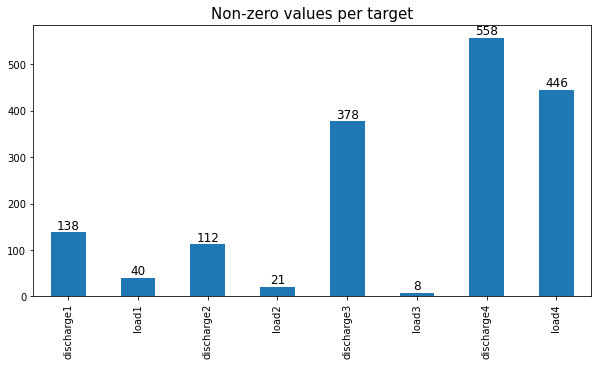

In [13]:
ax = targets_df.apply(lambda x: x[x > 0].count()).plot.bar(figsize = (10,5))
ax.bar_label(ax.containers[0], fontsize = 12)
ax.set_title('Non-zero values per target', fontsize = 15)
plt.show()

#### TARGETS INITIAL INSIGHTS
Based on a quick search https://bulkcarrierguide.com/cargo.html, I proceeded with an assumption: <br>
The handling of ore & coal could be similar (i.e., solid bulk cargo).<br>
Likewise, oil & petrol (i.e., liquid bulk) might have similar handling routines in terms of safety, regulations, transportation. <br>
Therefore, we can maximize the supervision signal by concatenating similar bulk load and discharge targets, such that:<br>

1. concatenate: load1 + load2 --> solid bulk load <br>
2. concatenate: load3 + load4 --> liquid bulk load <br>
3. concatenate: discharge1 + discharge2 --> solid bulk discharge <br>
4. concatenate: discharge3 + discharge4 --> liquid bulk discharge  <br>
5. Construct a binary variable ```bulk``` to define the cargo type {'solid': 0, 'liquid': 1}

In [14]:
processor = preprocess(dataframe= df)
targs = processor.format_targets(targets_df)
targs

,bulk,load,discharge
5,solid,NaN,72741.0
23,solid,4188.0,NaN
44,solid,39786.0,NaN
62,solid,NaN,50743.0
88,solid,7005.0,NaN
...,...,...,...
8188,liquid,NaN,15980.0
8191,liquid,4206.0,4196.0
8192,liquid,NaN,139431.0
8194,liquid,NaN,28127.0


### FEATURES SELECTION & ENGINEERING

1. Dropping non-informative features, (i.e., id columns): ['previousportid', 'nextportid','vesselid']
2. Engineering a new feature ```n_stevs``` outlining the number of stevedores per ship
3. Construct a ```process_time``` feature as the difference in days from the 2 dates ```latesteta ``` - ```earliesteta```



In [5]:
pd.options.mode.chained_assignment = None
processor = preprocess(dataframe= df)
feature_df = processor.format_features()
feature_df

,vesseldwt,vesseltype,traveltype,n_stevs,process_time,bulk,load,discharge
0,109290.0,5.0,ARRIVAL,1,0,liquid,NaN,90173.0
5,74518.0,2.0,ARRIVAL,1,0,solid,NaN,72741.0
8,17069.0,5.0,ARRIVAL,1,1,liquid,NaN,14044.0
23,7133.0,3.0,ARRIVAL,1,0,solid,4188.0,NaN
27,158070.0,5.0,ARRIVAL,1,0,liquid,NaN,131231.0
...,...,...,...,...,...,...,...,...
8188,25432.0,5.0,ARRIVAL,1,0,liquid,NaN,15980.0
8191,4993.0,5.0,SHIFT,2,7,liquid,4206.0,4196.0
8192,158583.0,5.0,SHIFT,2,8,liquid,NaN,139431.0
8194,37296.0,5.0,ARRIVAL,1,0,liquid,NaN,28127.0


Investigating missing values

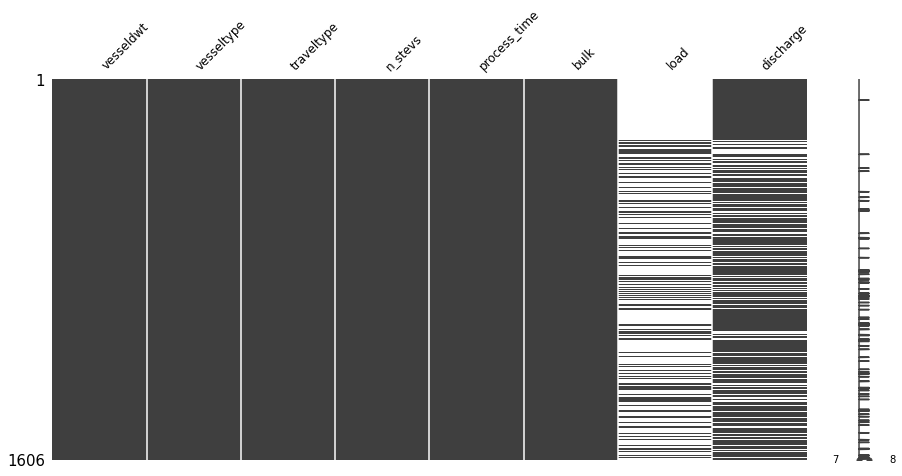

In [16]:
msno.matrix(feature_df.sort_values(by=['vesseltype'], ascending=True), figsize= (15,7), fontsize = 12)
plt.show()

D:\anaconda3\envs\omdena\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


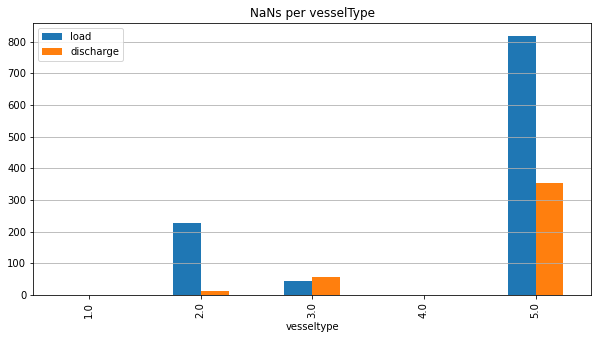

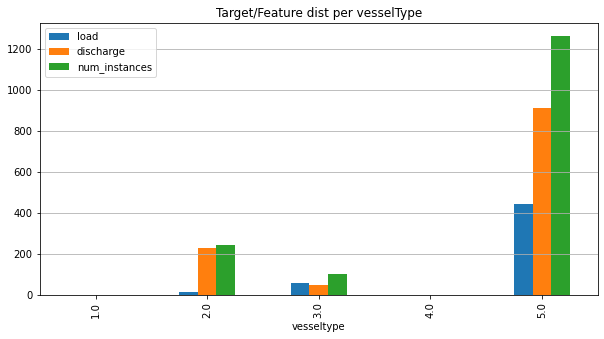

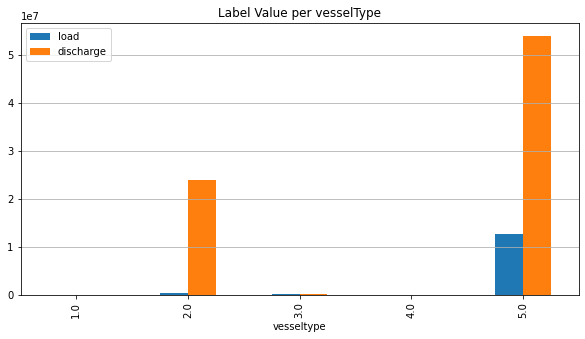

In [17]:
feature_df[['load','discharge']].isna().groupby(by=feature_df['vesseltype']).sum().plot.bar(figsize = (10,5), title = 'NaNs per vesselType')
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge', 'vesseltype']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Target/Feature dist per vesselType')
plt.legend(['load','discharge','num_instances']) 
plt.grid(axis = 'y', linestyle='-')
feature_df[['load','discharge']].groupby(by=feature_df['vesseltype'], dropna= True).sum().plot.bar(figsize = (10,5), title = 'Label Value per vesselType')
plt.grid(axis = 'y', linestyle='-')
# feature_df[['vesseltype']].groupby(by=feature_df['vesseltype'], dropna= True).count().plot.bar(figsize = (10,5), title = 'Row Count per vesseltype')
plt.show()



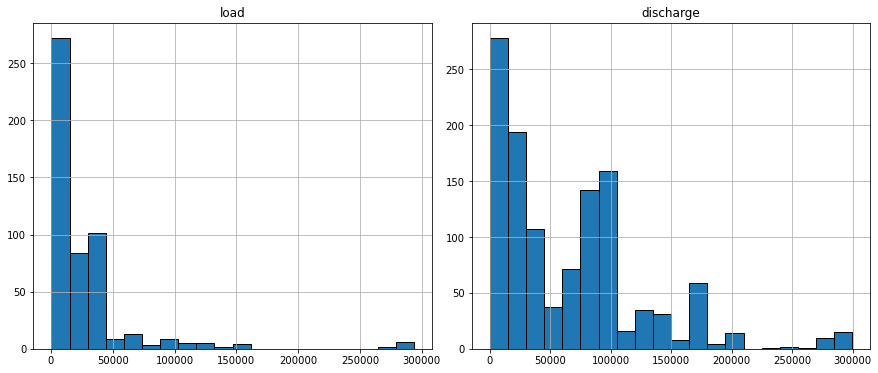

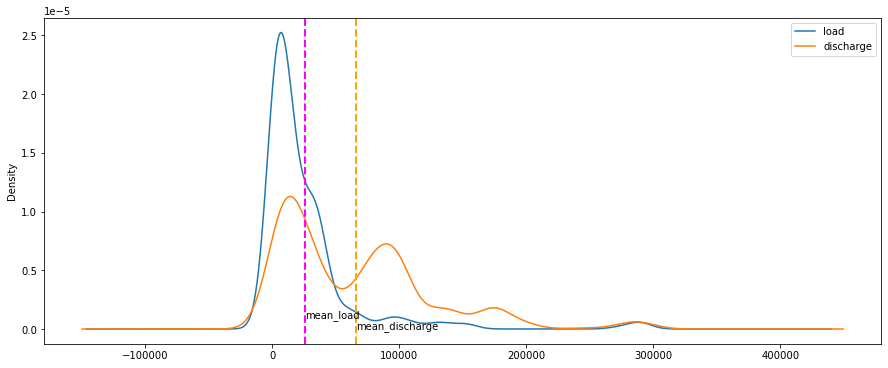

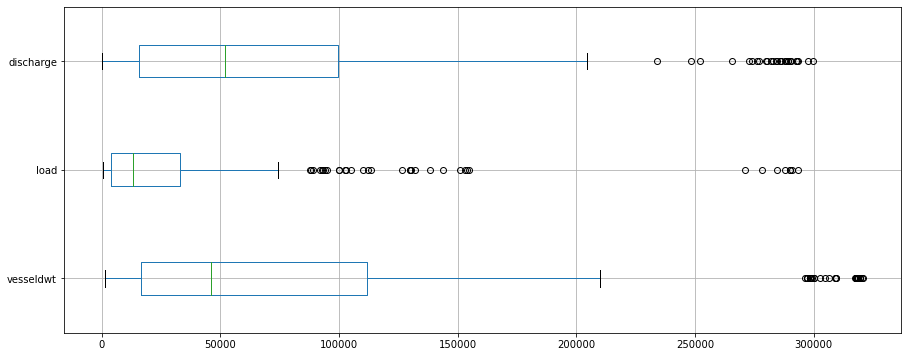

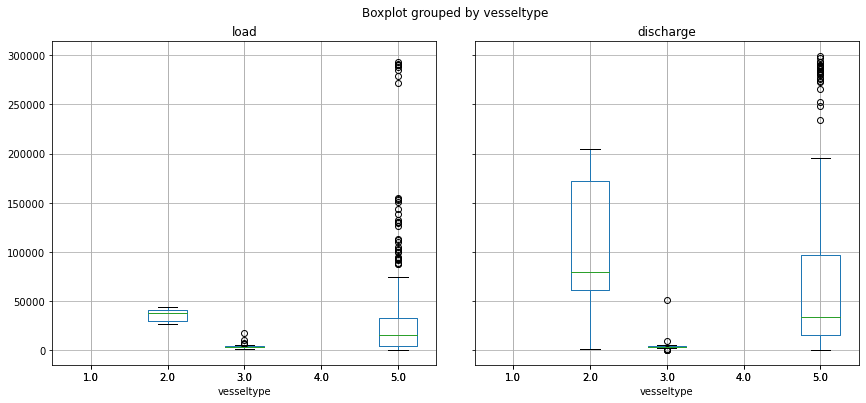

In [18]:
load_mean = feature_df['load'].mean()
discharge_mean = feature_df['discharge'].mean()
feature_df.hist(['load', 'discharge'], bins=20, figsize=(15,6), edgecolor='k')
plt.subplots_adjust(wspace= 0.1)
feature_df[['load','discharge']].plot.density(bw_method = 0.2, figsize = (15,6))
plt.axvline(x=load_mean, color = 'magenta', linestyle='dashed', linewidth = 2)
plt.axvline(x=discharge_mean, color = 'orange', linestyle='dashed', linewidth = 2)
plt.text(load_mean, y= 0.1e-5, s= 'mean_load')
plt.text(discharge_mean, y= 0, s= 'mean_discharge')
plt.subplots_adjust(wspace= 0.0001)
plt.show()
feature_df.boxplot(['vesseldwt','load','discharge'], vert = False, figsize=(15,6))
feature_df.boxplot(['load','discharge'], by='vesseltype', figsize=(14,6))
plt.subplots_adjust(wspace= 0.1)

plt.show()

#### FEATURE ENCODING:
One-hot encoding the categorical variables, and returning separate load/discharge dataset. Our focus at this stage is predicting discharge.

In [6]:
load_dataset, discharge_dataset = processor.encode_features()
discharge_dataset

,vesseldwt,n_stevs,process_time,discharge,vesseltype_1.0,vesseltype_2.0,vesseltype_3.0,vesseltype_4.0,vesseltype_5.0,traveltype_ARRIVAL,traveltype_SHIFT,bulk_liquid,bulk_solid
0,109290.0,1,0,90173.0,0,0,0,0,1,1,0,1,0
5,74518.0,1,0,72741.0,0,1,0,0,0,1,0,0,1
8,17069.0,1,1,14044.0,0,0,0,0,1,1,0,1,0
27,158070.0,1,0,131231.0,0,0,0,0,1,1,0,1,0
36,111775.0,1,2,99862.0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188,25432.0,1,0,15980.0,0,0,0,0,1,1,0,1,0
8191,4993.0,2,7,4196.0,0,0,0,0,1,0,1,1,0
8192,158583.0,2,8,139431.0,0,0,0,0,1,0,1,1,0
8194,37296.0,1,0,28127.0,0,0,0,0,1,1,0,1,0


# BALANCING PIPELINE

In [8]:
from sklearn.model_selection import train_test_split
X = discharge_dataset.drop('discharge', axis= 1)
y = discharge_dataset[['discharge']]

############################################
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size= 0.2, shuffle= True)
print (xtrain.shape, xtest.shape)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size= 0.25, shuffle= True)
print (xtrain.shape, xval.shape)

(947, 12) (237, 12)
(710, 12) (237, 12)


In [11]:
xtest.columns

Index(['vesseldwt', 'n_stevs', 'process_time', 'vesseltype_1.0',
       'vesseltype_2.0', 'vesseltype_3.0', 'vesseltype_4.0', 'vesseltype_5.0',
       'traveltype_ARRIVAL', 'traveltype_SHIFT', 'bulk_liquid', 'bulk_solid'],
      dtype='object')

### 1. SMOGN
Below is a demonstration of applying `synthetic oversampling with gaussian noise (SMOGN) on a training split.

r_index: 100%|##########| 6/6 [00:00<00:00, 375.88it/s]


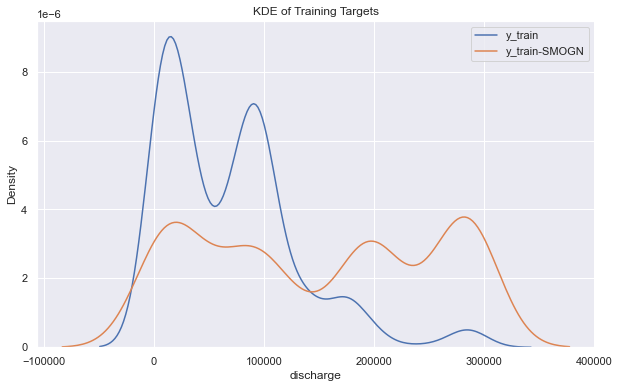

In [ ]:
xout, yout = apply_smogn(xtrain, ytrain)
traindata = pd.concat([xout, yout],axis= 1).reset_index()

fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.kdeplot(ytrain.discharge, ax = ax)
# # sns.kdeplot(simple.discharge, ax = ax[1])
sns.kdeplot(traindata.discharge, ax = ax)
plt.legend(['y_train', 'y_train-SMOGN'])
plt.title('KDE of Training Targets')
plt.show()


### 2. LDS - KERNEL SMOOTHING
Label distribution smoothing aims to address the discontinuity in the regression target space, by smoothing and approximating an effective distribution of the targets from their original empirical distribution. <br>

Below is a demonstration of estimating the LDS distibution by rebinning the discharge targets and subsequently using this distribution to calcuate `Inverse frequency reweighing`` for each data point.

In [ ]:
from  importlib import reload
import utils
reload(utils)
from utils import *

lds = LDS(labels= ytrain.discharge, buffer= 10000)
bin_df = lds.bin_dataframe(ytrain)
x_wts_df = lds.weight_df(bin_df, weight= 'inverse')
x_wts_df

,discharge,bin,inverse
5934,96562.0,97000,1.457735
1085,75279.0,76000,1.341116
5712,59203.0,60000,1.457735
6203,16001.0,17000,0.493057
2376,78448.0,79000,1.117597
...,...,...,...
6383,165516.0,166000,1.523996
4523,100052.0,101000,0.399142
878,59010.0,60000,1.457735
7296,31272.0,32000,0.957940


D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
D:\anaconda3\envs\omdena\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


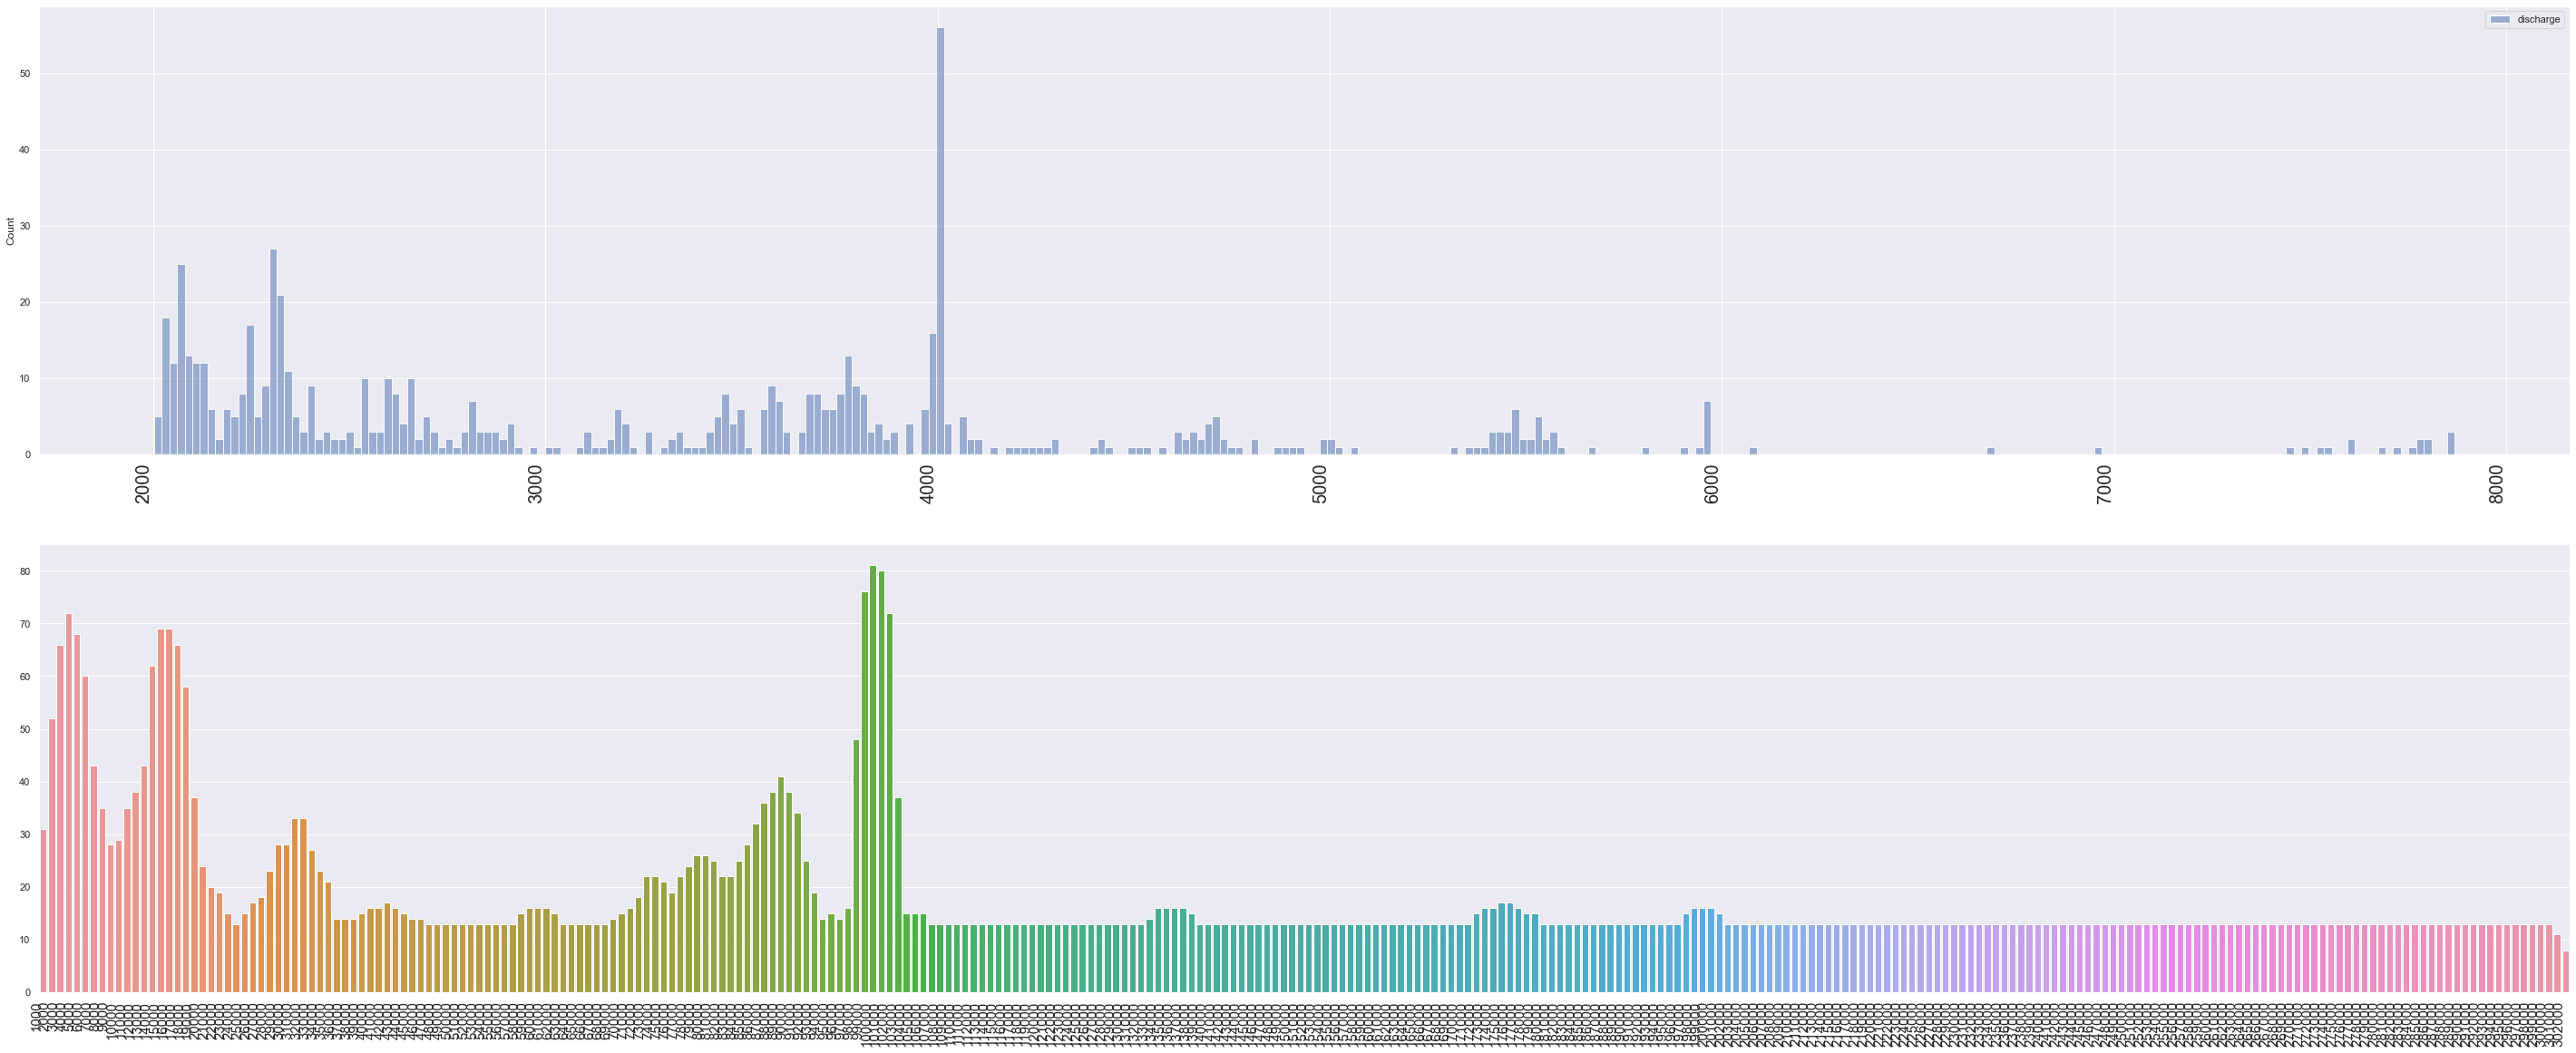

In [ ]:
smoothed, emp = lds.effective_dist(smooth= 3)
bins, freqs = zip(*emp.items())

sns.set(font_scale = 1)
fig, (ax0, ax1) = plt.subplots(2,1, figsize= (50,20), )
# sns.barplot(x= list(bins), y= list(freqs), ax =ax0)
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=90, ha='right')

sns.histplot(data= ytrain, ax =ax0, bins = 300)
ax0.set_xticklabels(bins, fontsize = 20)

bins, freqs = zip(*smoothed.items())
p = sns.barplot(x= list(bins), y= list(freqs), ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='right', fontsize = 15)
plt.subplots_adjust(hspace= .2)
plt.show()

# INTEGRATED CROSS VALIDATION PIPELINE

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV,ShuffleSplit, PredefinedSplit, LeaveOneOut, cross_val_score, cross_val_predict, KFold, GroupKFold, HalvingRandomSearchCV, RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, median_absolute_error
from scipy.stats import t

#### FITTING A VANILLA XBGOOSTER

In [ ]:
params = {'objective': 'reg:squarederror' , 'learning_rate': 0.3, 'gamma': 0, 'max_depth': 6, 'missing': 0, 'seed': 32 , 'subsample': 0.5, 'colsample_bytree': 0.5,
'reg_lambda': 0, 'n_estimators': 3000, 'eval_metric': ['mae']}
vanilla = xgb.XGBRegressor(**params, verbosity = 1, validate_parameters = True)
eval_sets = [ (xtrain, ytrain), (xval, yval)]
# model.get_xgb_params()

In [ ]:
vanilla.fit(xtrain, ytrain, eval_set= eval_sets, verbose= True, early_stopping_rounds= 10 )

[0]	validation_0-mae:51711.48047	validation_1-mae:52023.30078
[1]	validation_0-mae:44776.72266	validation_1-mae:45961.53906
[2]	validation_0-mae:32953.67188	validation_1-mae:33957.05469
[3]	validation_0-mae:25371.34375	validation_1-mae:26857.37109
[4]	validation_0-mae:24247.29492	validation_1-mae:25892.60156
[5]	validation_0-mae:19597.45508	validation_1-mae:21890.28906
[6]	validation_0-mae:16318.77441	validation_1-mae:19422.24219
[7]	validation_0-mae:16158.78125	validation_1-mae:19325.58984
[8]	validation_0-mae:13667.04394	validation_1-mae:17421.49805
[9]	validation_0-mae:13528.86914	validation_1-mae:17413.73828
[10]	validation_0-mae:11902.56348	validation_1-mae:16202.28027
[11]	validation_0-mae:11161.02246	validation_1-mae:15364.45215
[12]	validation_0-mae:10534.28906	validation_1-mae:15419.99414
[13]	validation_0-mae:10522.11426	validation_1-mae:15389.07129
[14]	validation_0-mae:10167.01172	validation_1-mae:15447.85644
[15]	validation_0-mae:10130.74414	validation_1-mae:15404.12402
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             eval_metric=['mae'], gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=0,
             monotone_constraints='()', n_estimators=3000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=32,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=32,
             subsample=0.5, tree_method='exact', validate_parameters=True,
             verbosity=1)

#### SEARCH SPACE

In [ ]:
#### RANDOM SEARCH DISTs
# 1. a beta prime distribution for gamma
gamma_dist = stats.betaprime(a = 2,b =6, scale = 10)

# 2. an exponential distribution for lambda
lambda_dist = stats.expon(scale = 3)

# 3. a log uniform distribution for learning rate
lr_dist = stats.loguniform(.0001, .5)

# 4. a negative binomial distribution for maxchild
maxchild_dist = stats.nbinom(2, .4, loc = 1)

# 5. a beta distribution for colsample_bytree
colrow_dist = stats.beta(2.5,1)

# 6. a negative binomial distribution for max_depth
treedepth_dist = stats.nbinom(20, .5)

search_space = {'objective': ['reg:squarederror'],
                'learning_rate':lr_dist,
                'max_depth':treedepth_dist,
                'subsample': colrow_dist,
                'colsample_bytree': colrow_dist,
                'reg_lambda': lambda_dist,
                'min_child_weight': maxchild_dist,
                'gamma': gamma_dist}


# EXECUTE PIPELINE

In [ ]:
# 1. setting the inner random parameter search loop @ k = 4 folds
inner_cv = RepeatedKFold(n_splits=4, n_repeats= 1, random_state= state)

# 2. setting the outer error estiamttion loop @ k = 4 folds
outer_cv = KFold(n_splits= 4, shuffle= True, random_state= state)

# 3. Initializing a set of parameters
init_params = vanilla.get_params()

Below is the execution of the Integrated balancing and nested cross validation pipeline

In [ ]:
from  importlib import reload
import pipeline
reload(pipeline)
import utils
reload(utils)
from pipeline import *

import smogn
reload(smogn)
from smogn import *

pipe = pipeline(vanilla.get_params(), inner_cv= inner_cv, outer_cv= outer_cv)

bestmodel, scores_df = pipe.nested_validation(X, y, n_candids= 30)
scores_df.to_pickle(datapath + 'scores_df.pkl')
scores_df

r_index: 100%|##########| 64/64 [00:00<00:00, 385.87it/s]


,model,score
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",5477.814453
1,"XGBRegressor(base_score=0.5, booster='gbtree',...",4901.831055
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",5762.511780
3,"XGBRegressor(base_score=0.5, booster='gbtree',...",7893.589844


### CV SCORES

In [ ]:
scores_df

,model,score
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",5477.814453
1,"XGBRegressor(base_score=0.5, booster='gbtree',...",4901.831055
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",5762.511780
3,"XGBRegressor(base_score=0.5, booster='gbtree',...",7893.589844


In [ ]:
bestmodel.save_model('/content/drive/MyDrive/Transshipment/models/bestmodel_2.json')

### BEST MODEL PARAMETERS

In [ ]:
bestmodel.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8801672539105327,
 'eval_metric': ['mae', 'rmse'],
 'gamma': 10.182123584678035,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.019437673150966728,
 'max_delta_step': 0,
 'max_depth': 16,
 'min_child_weight': 4,
 'monotone_constraints': '()',
 'n_jobs': 2,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 32,
 'reg_alpha': 0,
 'reg_lambda': 6.261495311486096,
 'scale_pos_weight': 1,
 'seed': 32,
 'subsample': 0.7212236249826819,
 'tree_method': 'exact',
 'validate_parameters': True,
 'verbosity': 1}

In [ ]:
pd.DataFrame.from_dict(bestmodel.get_xgb_params(), orient= 'index')

,0
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.880167
gamma,10.182124
gpu_id,-1
interaction_constraints,
learning_rate,0.019438
max_delta_step,0


### FEATURE IMPORTANCE

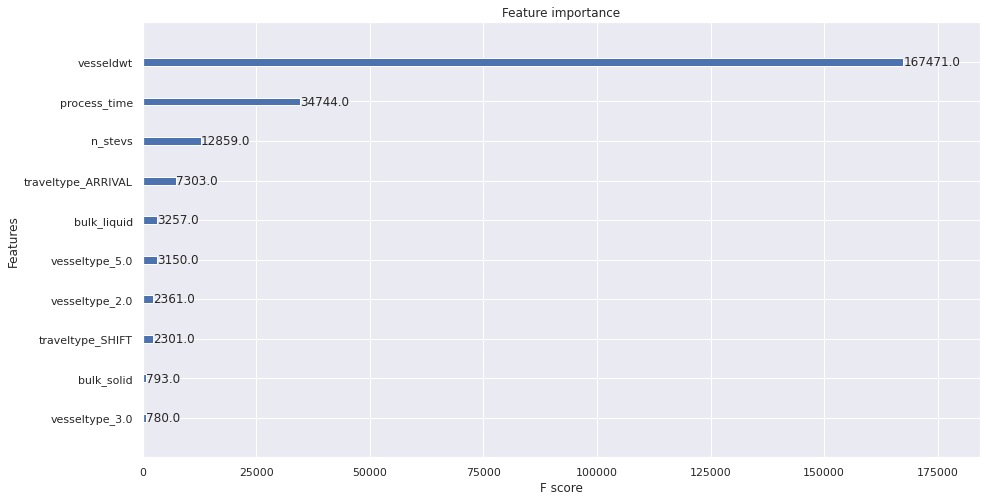

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(bestmodel, ax = ax)
plt.show()

### INSTANCES OF THE ESTIMATOR TREES

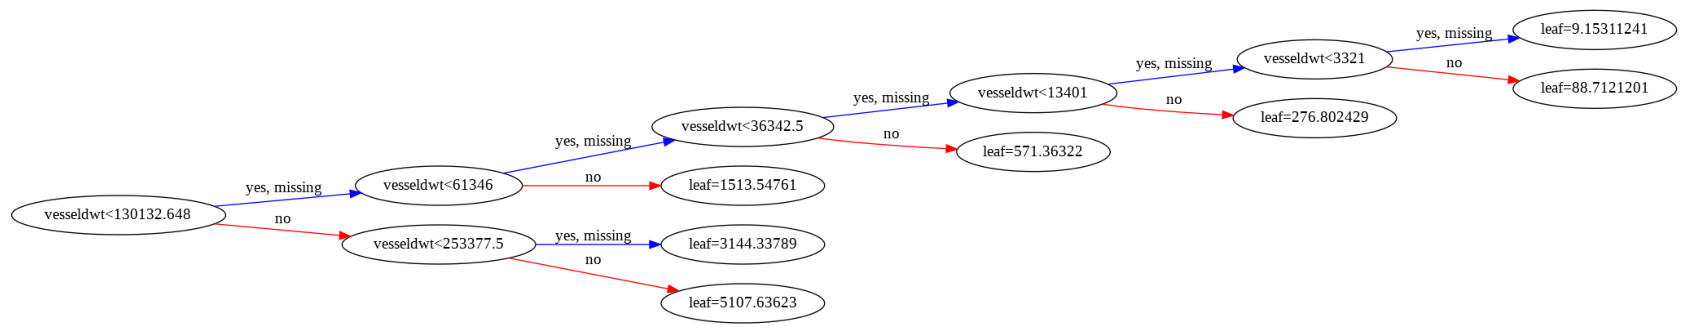

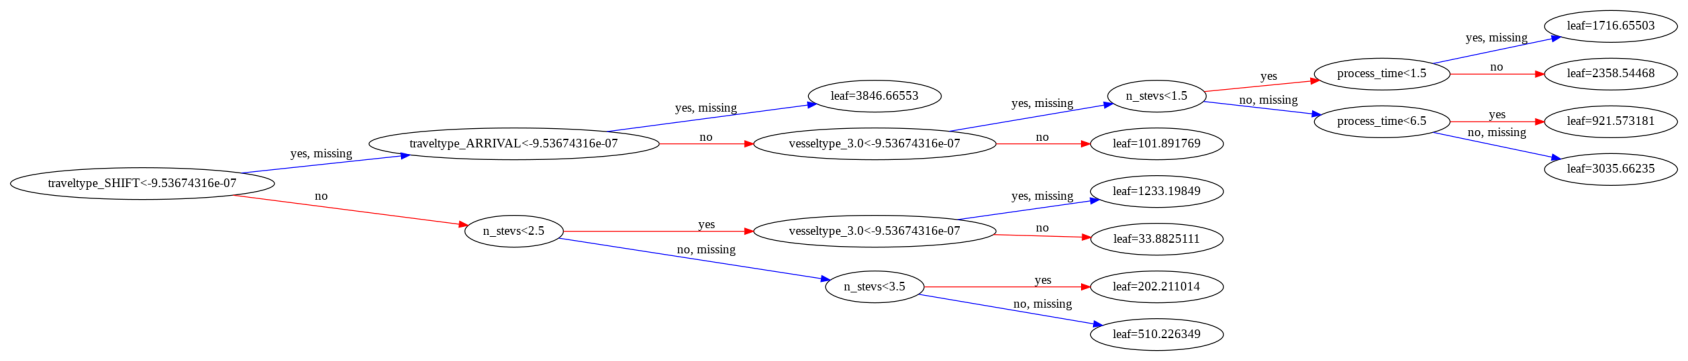

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
xgb.plot_tree(bestmodel, num_trees= 0,  ax = ax, rankdir= 'LR')

fig, ax = plt.subplots(figsize=(30, 20))
xgb.plot_tree(bestmodel, num_trees= 10,  ax = ax, rankdir= 'LR')
plt.show()

In [ ]:
m = xgb.XGBRegressor()
m.load_model(modelspath + 'bestmodel_2.json')
m

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8801672539105327,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             gamma=10.182123584678035, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.019437673150966728,
             max_delta_step=0, max_depth=16, min_child_weight=4, missing=0,
             monotone_constraints='()', n_estimators=3000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=32,
             reg_alpha=0, reg_lambda=6.261495311486096, scale_pos_weight=1,
             seed=32, subsample=0.7212236249826819, tree_method='exact',
             validate_parameters=True, verbosity=1)